# Statistics coded: 

Objective of this notebook is illustrating the "Statistics Explained" article.

"Statistics Explained" in general: "https://ec.europa.eu/eurostat/statistics-explained/index.php/Main_Page"

Article: Tourism Statistics "https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Tourism_statistics"

Prepared by Sarah Hadj Hassen.



In [303]:
# if necessary install the following packages and load them afterwards
# install.packages(c("ggplot2", "plotly", "tidyr", "repr", "dplyr", "devtools", "restatapi", "eurostat", 
#                    "patchwork", "Matching", "ggforce", "h2o", "plyr"))

library(ggplot2)
library(tidyr)
library(dplyr)
library(eurostat)
library(Matching)
library(stats)
library(base)
library(ggforce)
library(h2o)
library(plyr)

# Tourism destinations - nights spent at tourist accomodation establishments, 2018

## create graph in abstract

In [304]:
# create the first graph: tourism destinations - nights spent at toursit accommondation establishments, 2018

# load the needed data
data <- get_eurostat(id="tour_occ_ninat") 

# we just need the data for 2018, therefore we add a column, which indicates only the year
data$year <- as.integer(substr(data$time,1,4))

# create a countries vector (this vector we can also use fot other graphs, if needed)
countr <- c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","PL","IE","CY","SE","HU","DK","SI",
            "MT","FI","SK","RO","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME","RS","MK","XK")

# to investigate the dataset, especially with building a subset in mind, we can look at the levels of the variables
# levels(data$geo)
# levels(data$c_resid)
# levels(data$nace_r2)

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_occ_ninat_date_code_TF.rds
Table  tour_occ_ninat  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_occ_ninat_date_code_TF.rds


In [305]:
# for Ireland, Slovenia, United Kingdom, Switzerland, Norway, Iceland, Montenegro, Serbia and Kosovo 
# we need 2018 monthly data

# load the needed data
data_month <- get_eurostat(id="tour_occ_nim")

# again: add a column, which indicates only the year and one with only the month
data_month$year <- as.integer(substr(data_month$time,1,4))
data_month$month <- as.integer(substr(data_month$time,6,7))

# create a vector, which includes only the countries mentioned above
countr_fig0 <- c("IE","SI","UK","CH","NO","IS","ME","RS","XK")

# build the subset we need for the graphik
data_mod <- subset(data_month, 
                    data_month$geo %in% countr_fig0 & #include just the countries of the vector above
                    data_month$year==2018 & #only values for 2018
                    data_month$c_resid=="FOR" & #just non-residents
                    data_month$nace_r2=="I551-I553"& #the classification we need
                    data_month$unit=="NR") #we need the unit "number"

# because we have monthly data - but need yearly data - we have to aggregate the data per country
data_mod <- aggregate(data_mod$values, by = list(geo = data_mod$geo), FUN = sum)
# name the second column 
names(data_mod)[2] <- "values"

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_occ_nim_date_code_TF.rds
Table  tour_occ_nim  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_occ_nim_date_code_TF.rds


In [306]:
# building needed subset for the other countries (same like above with the datsat "data")
data_mod2 <- subset(data, 
                    data$geo %in% countr & 
                    data$year==2018 &
                    data$c_resid=="FOR" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")
# we only need column 4 and 6 for the following analysis
data_mod2 <- data_mod2[,c(4,6)]

In [307]:
# for Turkey we need data from 2016
# create a vector, which includes only the country mentioned 
countr_fig0_1 <- c("TR")

# building needed subset
data_mod3 <- subset(data, 
                    data$geo %in% countr_fig0_1 & 
                    data$year==2016 & 
                    data$c_resid=="FOR" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")
# we only need column 4 and 6 for the following analysis
data_mod3 <- data_mod3[,c(4,6)] 

In [308]:
# match data_mod1 and data_mod2 and data_mod3, i.e. use rbind to stick the data frames together
# we get the final dataset for the graph
data_mod4 <- rbind(data_mod,data_mod2,data_mod3)

In [309]:
# bring the country names in the order the graphik shows
# you can do this due to modify the levels of the variable "geo"
data_mod4$geo <- factor(data_mod4$geo,
                        levels = c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","PL","IE","CY","SE","HU",
                                   "DK","SI", "MT","FI","SK","RO","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME",
                                   "RS","MK","XK"))

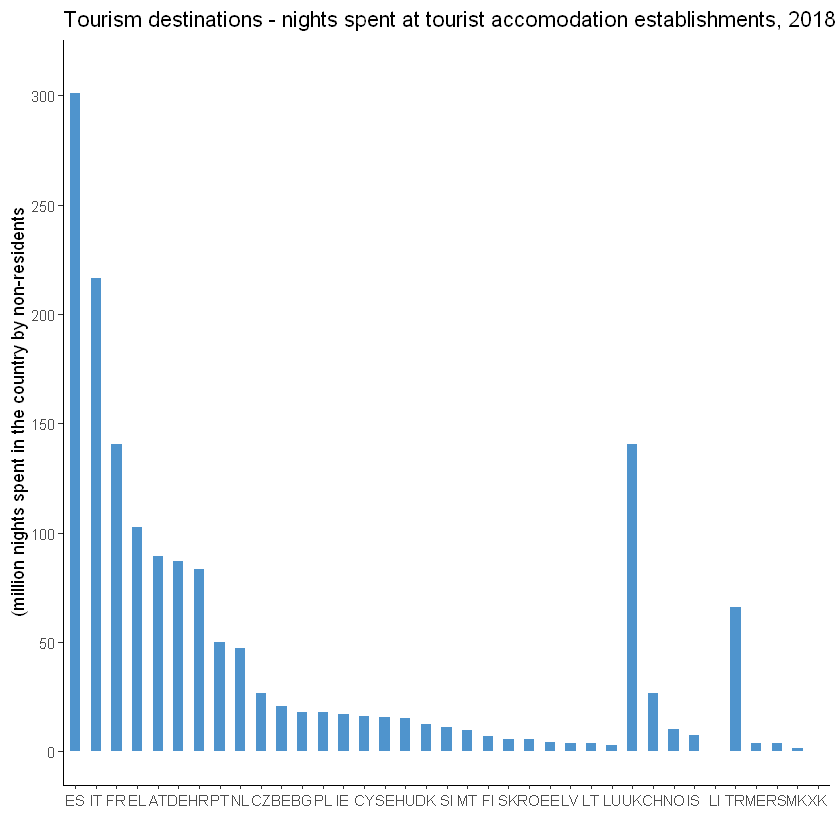

In [310]:
options(scipen=999) # prevent scientific notation
label_axes1 <- seq(0, 300, by = 50)

# finally use the modified dataset and build the graph by using ggplot
ggplot(data_mod4, #needed dataset
       aes(x=geo,y=values)) + #the axes you want
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") + #for creating a bar chart
            theme_classic() +
            scale_y_continuous(limits = c(0, 310000000), breaks = seq(0, 300000000, by = 50000000), #limit the axes
                              labels=label_axes1) + #label the axes
            ggtitle("Tourism destinations - nights spent at tourist accomodation establishments, 2018") +
            ylab("(million nights spent in the country by non-residents") + #name the axes
            xlab(" ")

# Bed places in the EU-27: Italy and France predominate


## create table 1

In [311]:
# create table 1: tourist accomodation establishments, 2018

# we need 3 datasets - one for each column
# create a countries vector: the countries are already in the same order the table shows
countr_0 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
              "AT","PL","PT","RO","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")

In [312]:
# column 1: number of establishments (units)
# load the needed data and add the year-column
data_1 <- get_eurostat(id="tour_cap_nat")
data_1$year <- as.integer(substr(data_1$time,1,4))

# exclude the countries, which need data from 2016 and 2017
countr_tab1 <- c("BE","BG","CZ","DK","DE","EE","EL","ES","FR","HR","IT","CY","LV","LT","HU","MT","NL",
              "AT","PL","PT","RO","SK","FI","SE","IS","LI","NO","CH","ME","MK","RS")
# building the subset we need for the first column of the table and choose column 4 and 6 again
data_tab1 <- subset(data_1, 
                    data_1$geo %in% countr_tab1 & 
                    data_1$year==2018 &
                    data_1$nace_r2=="I551-I553"&
                    data_1$unit=="NR"&
                    data_1$accommod=="ESTBL")
data_tab1 <- data_tab1[,c(4,6)]

# for Ireland and United Kingdom we need data from 2016
countr_tab1_1 <- c("IE","UK")
data_tab1_1 <- subset(data_1, 
                      data_1$geo %in% countr_tab1_1 & 
                      data_1$year==2016 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="ESTBL")
data_tab1_1 <- data_tab1_1[,c(4,6)]

# for Luxembourg, Slovenia and Kosovo we need data from 2017
countr_tab1_2 <- c("LU","SI","XK")
data_tab1_2 <- subset(data_1, 
                      data_1$geo %in% countr_tab1_2 & 
                      data_1$year==2017 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="ESTBL")
data_tab1_2 <- data_tab1_2[,c(4,6)]

# for Turkey we have NA
data_tab1_3 <- data.frame( geo = "TR", values=  NA)

# matching
data_tab_col1 <- rbind(data_tab1,data_tab1_1,data_tab1_2,data_tab1_3)

# bring the country names in the order the grpahik shows
data_tab_col1 <- data_tab_col1[order(factor(data_tab_col1$geo, levels= countr_0)),]

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_cap_nat_date_code_TF.rds
Table  tour_cap_nat  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_cap_nat_date_code_TF.rds


In [313]:
# column 2: number of bed places (thousands)

# exclude the countries, which need data from 2016 and 2017
countr_tab2 <- c("BE","BG","CZ","DK","DE","EE","EL","ES","FR","HR","IT","CY","LV","LT","HU","MT","NL",
              "AT","PL","PT","RO","SK","FI","SE","IS","LI","NO","CH","ME","MK","RS","TR")
data_tab2 <- subset(data_1, 
                    data_1$geo %in% countr_tab2 & 
                    data_1$year==2018 &
                    data_1$nace_r2=="I551-I553"&
                    data_1$unit=="NR"&
                    data_1$accommod=="BEDPL")
data_tab2 <- data_tab2[,c(4,6)]

# for Ireland and United Kingdom we need data from 2016
countr_tab2_1 <- c("IE","UK")
data_tab2_1 <- subset(data_1, 
                      data_1$geo %in% countr_tab2_1 & 
                      data_1$year==2016 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="BEDPL")
data_tab2_1 <- data_tab2_1[,c(4,6)]

# for Luxembourg, Slovenia and Kosovo we need data from 2017
countr_tab2_2 <- c("LU","SI","XK")
data_tab2_2 <- subset(data_1, 
                      data_1$geo %in% countr_tab2_2 & 
                      data_1$year==2017 &
                      data_1$nace_r2=="I551-I553"&
                      data_1$unit=="NR"&
                      data_1$accommod=="BEDPL")
data_tab2_2 <- data_tab2_2[,c(4,6)]

# for Turkey we have NA
data_tab2_3 <- data.frame( geo = "TR", values=  NA)

# matching
data_tab_col2 <- rbind(data_tab2,data_tab2_1,data_tab2_2,data_tab2_3)

# bring the country names in the order the grpahik shows
data_tab_col2 <- data_tab_col2[order(factor(data_tab_col2$geo, levels= countr_0)),]

In [314]:
# column 3: nights spent by residents and non-residents (millions)

# exclude the countries, which need monthly data and data from 2016
countr_tab3 <- c("BE","BG","CZ","DK","DE","EE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
              "AT","PL","PT","RO","SK","FI","SE","LI","MK","TR")

# we already load the data for the graph before
data_tab3 <- subset(data, 
                    data$geo %in% countr_tab3 & 
                    data$year==2018 &
                    data$c_resid=="TOTAL" &
                    data$nace_r2=="I551-I553"&
                    data$unit=="NR")
data_tab3 <- data_tab3[,c(4,6)]

# for Ireland, Slovenia, United Kingdom, Switzerland, Norway, Iceland, Montenegro, Serbia and Kosovo 
# we need 2018 monthly data
# we already load the data for the graph before
countr_tab3_1 <- c("IE","SI","UK","CH","NO","IS","ME","RS","XK")

data_tab3_1 <- subset(data_month, 
                    data_month$geo %in% countr_tab3_1 & 
                    data_month$year==2018 &
                    data_month$c_resid=="TOTAL" &
                    data_month$nace_r2=="I551-I553"&
                    data_month$unit=="NR")
data_tab3_1 <- aggregate(data_tab3_1$values, by = list(geo = data_tab3_1$geo), FUN = sum)
names(data_tab3_1)[2] <- "values"

# for Turkey we need data from 2016
countr_tab3_2 <- c("TR")

data_tab3_2 <- subset(data, 
                      data$geo %in% countr_tab3_2 & 
                      data$year==2016 &
                      data$c_resid=="TOTAL" &
                      data$nace_r2=="I551-I553"&
                      data$unit=="NR")
data_tab3_2 <- data_tab3_2[,c(4,6)]
 

# matching
data_tab_col3 <- rbind(data_tab3,data_tab3_1,data_tab3_2)

# bring the country names in the order the grpahik shows
data_tab_col3 <- data_tab_col3[order(factor(data_tab_col3$geo, levels= countr_0)),]

In [315]:
# create a column with the names of the countries
countr_names <- c("Belgium","Bulgaria","Czechia","Denmark","Germany","Estonia", "Ireland", "Greece", "Spain", "France", 
                  "Croatia", "Italy", "Cyprus", "Latvia", "Lithuania", "Luxembourg", "Hungary", "Malta", "Netherlands", 
                  "Austria", "Poland", "Portugal", "Romania", "Slovenia", "Slovakia", "Finland", "Sweden",
                 "United Kingdom", "Iceland", "Liechtenstein", "Norway", "Switzerland", "Montenegro", "North Macedonia", 
                  "Serbia", "Turkey", "Kosovo")

# matching all columns together to create the data for the final table
table <- cbind(countr_names, data_tab_col1[,2], data_tab_col2[,2], data_tab_col3[,2])

In [323]:
# calculate the EU-27 value by summing up

# first we create the vector with the 27 countries, we will use this vector in other graphics, too
EU_27 <- c("AT","BE", "BG","HR","CY", "CZ","DK", "DE", "EE","FI","FR","EL","HU","IE",
           "IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE")

# we need the table from above (the three columns) with shortcuts instead of full names to exclude the not-EU countries 
# by using the EU_27 vector
# therefore we add the countr_0 vector, which we create in the first step
tab_prep <- cbind(countr_0,data_tab_col1[,2], data_tab_col2[,2], data_tab_col3[,2])

# create a vector, which indicates due to FALSE and TRUE at the exact position, which countries of countr_0 are within EU_27
EU_27_prep <- tab_prep$countr_0 %in% EU_27

# by using the sapply-command we can calculate the sum for each column of the table "table"
tab_EU <- c("EU-27",sapply(table[EU_27_prep,2:4],sum))                

# put the summarized values to the calculated table "table" from above
# at this stage we get the warning message, that one NA for "Eu-27" get generated,
# we solve this problem two steps later
table_final <- rbind(tab_EU,table)

# give the columns the correct names
names(table_final) <- c("", "Number of establishments /n (units)", "Number of bed places /n (thousands)",
                       "Nights spent by residents and /n non-residents (millions)")

# we have to convert the class, because we have to add "EU-27" and this only works by converting it from 
# a factor first, then doing the change and re-convert it back
table_final[,1] <- as.character(table_final[,1])
table_final[1,1] <- "EU-27"
table_final[,1] <- factor(table_final[,1])

# we want to modify the numbers: second column in thousands and third columns in millions
table_final[,3] <- round(as.numeric(table_final[,3])/ 1000,0)
table_final[,4] <- round(as.numeric(table_final[,4])/ 1000000,1)

table_final

Warning message in `[<-.factor`(`*tmp*`, ri, value = "EU-27"):
"invalid factor level, NA generated"

,Number of establishments /n (units),Number of bed places /n (thousands),Nights spent by residents and /n non-residents (millions)
<fct>,<chr>,<dbl>,<dbl>
EU-27,600157,28294,2791.2
Belgium,9211,390,41.3
Bulgaria,3458,336,26.8
Czechia,9426,741,55.5
Denmark,1167,426,33.3
Germany,50020,3474,419.6
Estonia,1535,61,6.6
Ireland,3145,200,33.4
Greece,38180,1340,123.1


# Nights spent by non-residents in the EU-27: Spain on top

## create figure 1

In [324]:
# choose the countries from the EU 2020 and build the country vector like we did above
EU_27 <- c("AT","BE", "BG","HR","CY", "CZ","DK", "DE", "EE","FI","FR","EL","HU","IE",
           "IT","LV","LT","LU","MT","NL","PL","PT","RO","SK","SI","ES","SE")

# we already load the data for the first graph we recreate

In [326]:
# due to we want to use a loop for getting the data for the three lines, we have to create a vector with the 
# essential difference between the three columns
night <- c("FOR","NAT","TOTAL")

# create an empty data frame, which we can fill while running the loop
# we have 3 lines and therefore 3 columns in the needed dataset
# and we have data for 14 years and therefore 14 rows in the needed dataset
data_fig1_final <- data.frame(year = c(2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018),
                                 FOR = numeric(14),
                                 NAT = numeric(14),
                                TOTAL = numeric(14))
# build the loop
for (i in 1:3) {

# we need the data from above (reminder: called data)
data_fig1 <- subset(data, 
                    data$geo == "EU27_2020" & 
                    data$year %in% c(2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018) & #timeintervall
                    data$c_resid== night[i] & #here we have the essential difference between the columns we create
                    data$unit=="PCH_PRE" &
                    data$nace_r2=="I551-I553") 

# for every year we have data from the 27 EU-countries
# we just need one aggregate value for every year
# data_fig1 <- aggregate(data_fig1$values, by = list(geo = data_fig1$year), FUN = mean) 

#print(data_fig1) #if you want to see the intermediate steps

#rbind.fill(data_fig1, data_fig1_final[,c(1,i)])
    
#data_fig1_final[,i] <- data_fig1[,2] #assigning the calculated data in each intermediate step to empty data frame
    
 }

In [327]:
# we have the index 2005=100, therefore we have to calculate the calulated sum beginning with 100 in 2005
# add for each of the three columns of data_fig1_final a corresponding cumsum-column
data_fig1_final$cum_values1 <- c(NA,cumsum(data_fig1_final[2:15,1]))
    data_fig1_final$cum_values2 <- c(NA,cumsum(data_fig1_final[2:15,2]))
    data_fig1_final$cum_values3 <- c(NA,cumsum(data_fig1_final[2:15,3]))

# add the cumsum-value to the 100 (index of 2005)
data_fig1_final$graph_values1 <- numeric(15)
    data_fig1_final$graph_values2 <- numeric(15)
    data_fig1_final$graph_values3 <- numeric(15)
data_fig1_final[1,7:9] <- 100   
data_fig1_final[2:15,7] <- data_fig1_final[2:15,4]+100
    data_fig1_final[2:15,8] <- data_fig1_final[2:15,5]+100
    data_fig1_final[2:15,9] <- data_fig1_final[2:15,6]+100
data_fig1_final <- data_fig1_final[,7:9]

# we need the year in the first column, so we have to add  again
data_fig1_final <- cbind(data_fig1[,1], data_fig1_final)
names(data_fig1_final)[1] <- "year"

# final dataset for the graph
data_fig1_final

ERROR: Error in `$<-.data.frame`(`*tmp*`, cum_values1, value = c(NA, 2006, 4013, : replacement has 15 rows, data has 14


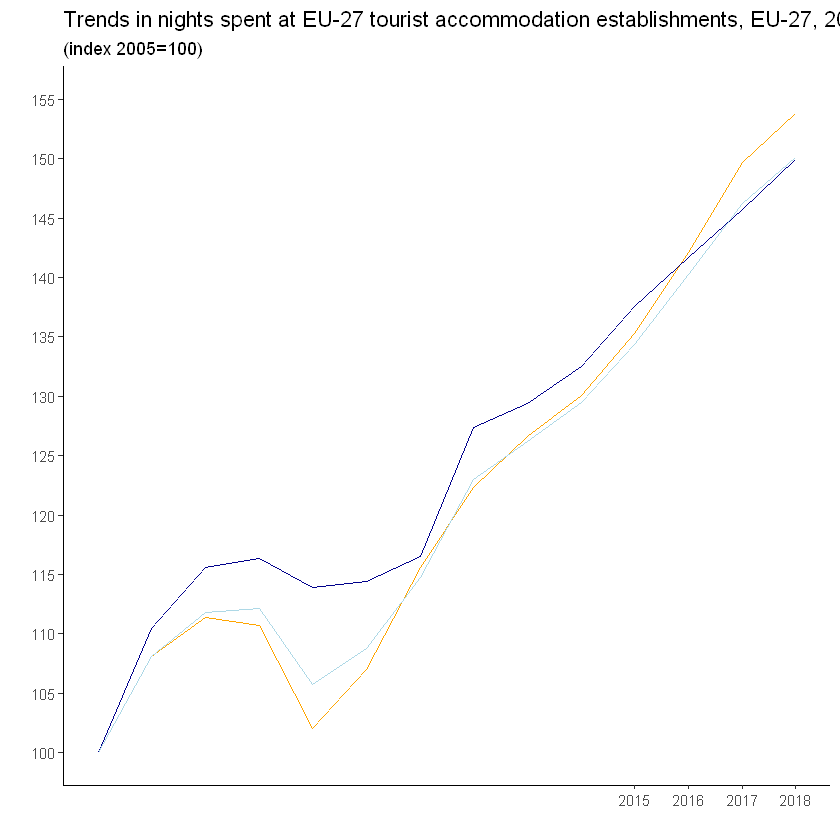

In [49]:
# finally use the modified dataset and build the graph by using ggplot
ggplot(data_fig1_final) + 
  geom_line(aes(x=year,y=graph_values1), color="orange") + #we add three lines
  geom_line(aes(x=year,y=graph_values2), color="darkblue") +
  geom_line(aes(x=year,y=graph_values3), color="lightblue") +
    theme(legend.position="bottom",legend.direction="vertical") + #add a legend
    ggtitle("Trends in nights spent at EU-27 tourist accommodation establishments, EU-27, 2005-2018",
        subtitle="(index 2005=100)") +
    scale_y_continuous(limits = c(100, 155), breaks = seq(100, 155, by = 5)) +
    scale_x_continuous(limits = c(2005, 2018), breaks = seq(2015, 2018, by = 1)) +
    theme_classic() +
    scale_color_manual(labels = c("Total nights spent", "Nights spent by non-residents", "Nights spent by residents"), 
    values = c("orange","blue","green"), name = " ") +
    ylab(" ") +
    xlab(" ")

## create figure 2

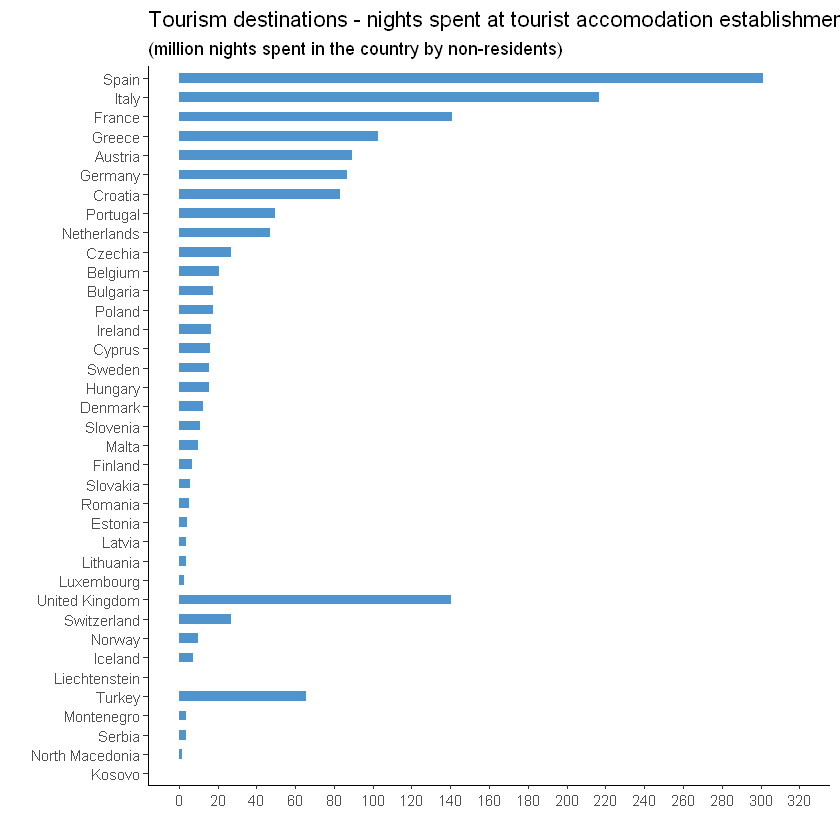

In [328]:
label_axes2 <- seq(0, 320, by = 20)

ggplot(data_mod4, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            theme_classic() +
            scale_y_continuous(limits = c(0, 320000000), breaks = seq(0, 320000000, by = 20000000),
                              labels=label_axes2) +
            ggtitle("Tourism destinations - nights spent at tourist accomodation establishments, 2018",
                   subtitle = "(million nights spent in the country by non-residents)") +
            coord_flip() +
            scale_x_discrete(limits = rev(levels(data_mod4$geo)),
                             labels = c("Kosovo", "North Macedonia", "Serbia", "Montenegro", "Turkey", "Liechtenstein", 
                                        "Iceland", "Norway", "Switzerland", "United Kingdom", "Luxembourg", "Lithuania", 
                                        "Latvia", "Estonia", "Romania", "Slovakia", "Finland", "Malta", "Slovenia", 
                                        "Denmark", "Hungary", "Sweden", "Cyprus", "Ireland", "Poland", "Bulgaria", 
                                        "Belgium", "Czechia", "Netherlands", "Portugal", "Croatia", "Germany", "Austria", 
                                        "Greece", "France", "Italy", "Spain")) +
            ylab(" ") +
            xlab(" ")

## create figure 3

In [329]:
# calculate the EU-27 value by summing up
# we already create the EU_27-vector
# create a vector, which indicates due to FALSE and TRUE at the exact position, which countries of countr_0 are within EU_27
EU_27_prep2 <- data_mod4$geo %in% EU_27

# by using the sapply-command we can calculate the sum for each column of the table "table"
tab_EU2 <- sapply(as.data.frame(data_mod4[EU_27_prep2,2]),sum)

# add a column with the ratios we need for the pie chart
tab_ratio <- cbind(data_mod4,data_mod4[2]/tab_EU2*100)

# shorten the table through EU_27_prep2 (countries outside the EU should be delete)
tab_ratio <- tab_ratio[EU_27_prep2,]

# sort the ratios in a decreasing order
tab_ratio <- tab_ratio[order(tab_ratio[,3], decreasing=T),]

# keep the top 9 countries and summing up the others to "Rest of EU-27" by using again the sapply command
tab_ratio_top9 <- tab_ratio[1:9,]
tab_ratio_other <- tab_ratio[10:27,]
tab_ratio_other_sum <- sapply(as.data.frame(tab_ratio_other[,3]),sum)
# add the sum to the top 9
tab_ratio_new <- rbind(tab_ratio_top9[,c(1,3)], tab_ratio_other_sum)
tab_ratio_new

Warning message in `[<-.factor`(`*tmp*`, ri, value = 15.9651602486859):
"invalid factor level, NA generated"

,geo,values
,<fct>,<dbl>
19,ES,22.645198
24,IT,16.287560
21,FR,10.586126
18,EL,7.716184
10,AT,6.717353
15,DE,6.541928
22,HR,6.254410
33,PT,3.750269
31,NL,3.535812


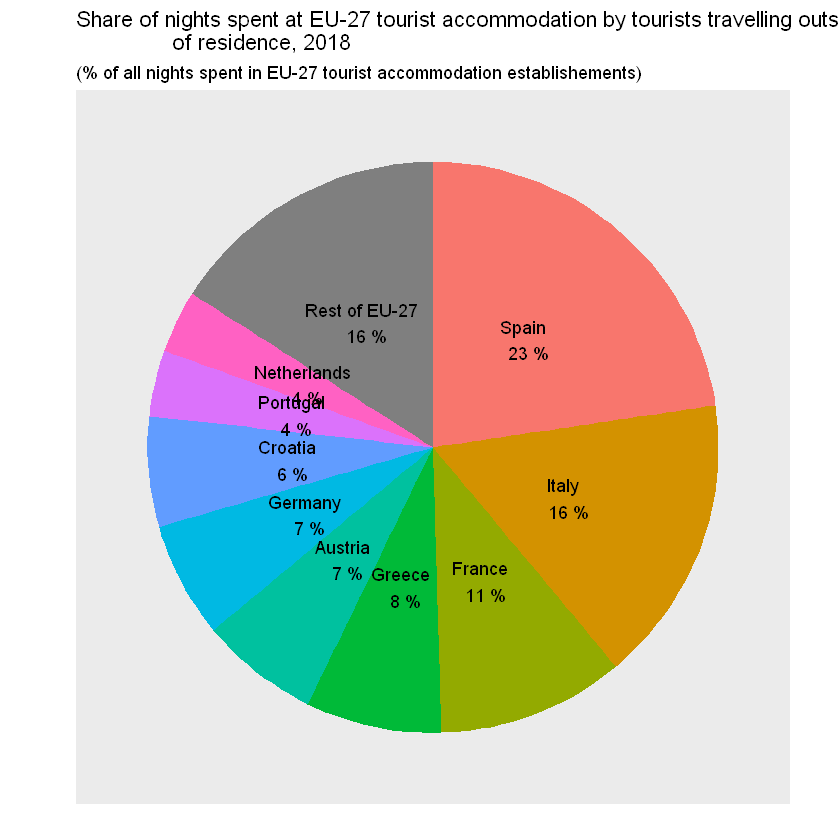

In [330]:
# create the labels: percentage and the country name
label_pie1 <- paste(round(tab_ratio_new$values,0), "%")
label_pie2 <- c("Spain","Italy","France","Greece","Austria","Germany","Croatia","Portugal","Netherlands","Rest of EU-27")
label_pie3 <- paste(label_pie2,"\n",label_pie1) #we can add "/n" to achieve a line break

# plot the pie chart 
ggplot(tab_ratio_new, aes(x="", y=values, fill=geo)) +
       geom_bar(stat = "identity", width=1) + #we have to create bars first
       coord_polar("y", direction = -1, start=0) + #afterwards we can convert it to a pie chart
       geom_text(label = label_pie3, position = position_stack(vjust = 0.5)) +
       ylab(" ") +
       xlab(" ") +
       ggtitle("Share of nights spent at EU-27 tourist accommodation by tourists travelling outside their own country 
                of residence, 2018",
                subtitle = "(% of all nights spent in EU-27 tourist accommodation establishements)") +
       theme(legend.position = "none") +
       theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid  = element_blank())

## create figure 4

In [331]:
# we already load the dataset and can use the values from the third colomn from table 1
# additionally we need the following dataset
bev <- get_eurostat(id="demo_gind")

# building the needed subset and choose only the relevant columns
bev_subs <- subset(bev, 
                   bev$geo %in% countr_0 & 
                   bev$indic_de=="JAN" &
                   bev$time=="2018-01-01")
bev_subs <- bev_subs[,c(2,4)]

# bring the country names in the same order like the table above to add the columns with the tourist accomodation
bev_subs <- bev_subs[order(factor(bev_subs$geo, levels= countr_0)),]

# add the columns with the tourist accomodation from data_tab_col3
bev_subs <- cbind(bev_subs,data_tab_col3)

# add the ratio-column
bev_subs <- cbind(bev_subs,bev_subs[,4]/bev_subs[,2])
names(bev_subs)[5] <- "values"

# create new country vector to bring the countries in the right order the graph shows
countr_fig4 <- c("HR", "MT","CY","AT","EL","ES","SI","PT","IT","IE","NL","FR","SE","DK","CZ","DE","EE","LU","FI","BG",
                 "BE","HU","LT","SK","LV","PL","RO", "UK", "IS","CH","NO","LI","ME","TR","RS","MK","XK")
# choose only the relevant columns
bev_subs <- bev_subs[,c(1,5)]

# bring the country names in the order the graphik shows
bev_subs <- bev_subs[order(factor(bev_subs$geo, levels= countr_fig4)),]

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/demo_gind_date_code_TF.rds
Table  demo_gind  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/demo_gind_date_code_TF.rds


In [332]:
# calculate the EU-27 value by summing up 

# create a vector, which indicates due to FALSE and TRUE at the exact position, 
# which countries of bev_subs$geo are within EU_27
# we can use again the EU_27 vector
EU_27_prep_2_1 <- bev_subs$geo %in% EU_27

# by using the sapply-command we can calculate the sum and the average for the column of the table "bev_subs"
# at this stage we get the warning message, that one NA for "Eu-27" get generated,
# we solve this problem two steps later
tab_EU2_1 <- c("EU-27",sapply(as.data.frame(bev_subs[EU_27_prep_2_1,2]),mean))

# put the summarized values to the calculated table from above
bev_subs <- rbind(tab_EU2_1,bev_subs)

# we have to convert the class, because we have to add "EU-27" and this only works by converting it from 
# a factor first, then doing the change and re-convert it back
bev_subs[,1] <- as.character(bev_subs[,1])
bev_subs[1,1] <- "EU-27"
bev_subs[,1] <- factor(bev_subs[,1])

bev_subs

Warning message in `[<-.factor`(`*tmp*`, ri, value = "EU-27"):
"invalid factor level, NA generated"

,geo,values
,<fct>,<chr>
1,EU-27,7.40005895207023
11,HR,21.8165401816542
18,MT,21.2616664669614
13,CY,19.8605265228479
20,AT,14.1946701454399
8,EL,11.4593880645163
9,ES,10.0076352091187
24,SI,7.58309287428394
22,PT,7.23033726371527


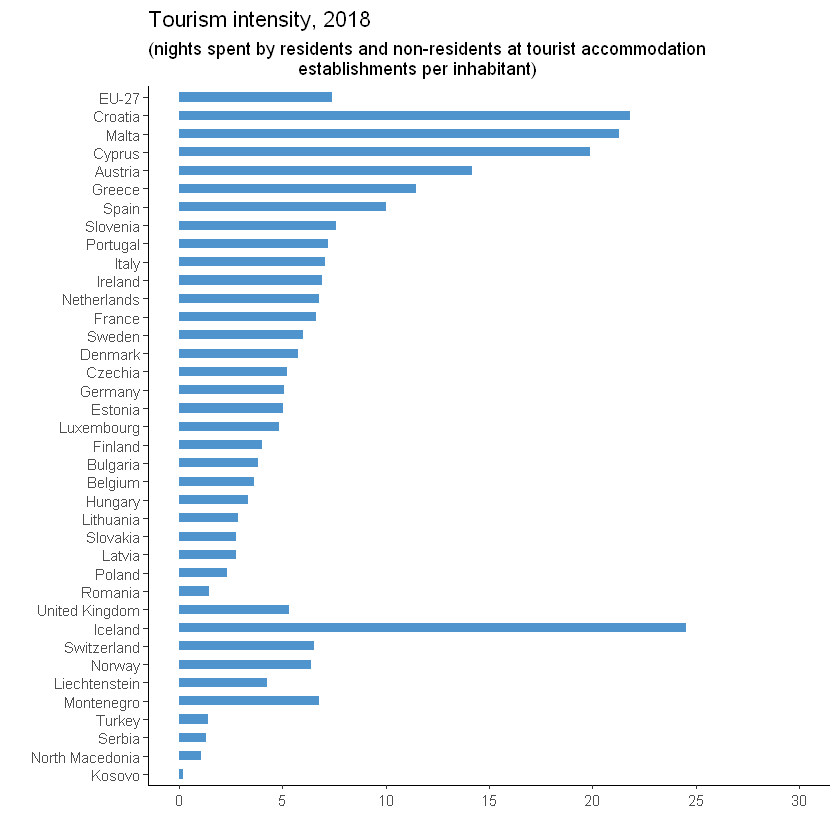

In [333]:
# bring the country names in the order the graphik shows
# you can do this due to modify the levels of the variable "geo"
bev_subs$geo <- factor(bev_subs$geo,
                        levels = c("EU-27","HR", "MT","CY","AT","EL","ES","SI","PT","IT","IE","NL","FR","SE","DK","CZ","DE",
                                   "EE","LU","FI","BG","BE","HU","LT","SK","LV","PL","RO", "UK", "IS","CH","NO","LI",
                                   "ME","TR","RS","MK","XK"))

# to achieve that the y-axes in the chart is later in an ascending order, we have to convert the ratio-axes to numeric
bev_subs$values <- as.numeric(as.character(bev_subs$values))

# plot the graph via ggplot
ggplot(bev_subs, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            theme_classic() +
            scale_y_continuous(limits = c(0, 30), breaks = seq(0, 30, by = 5)) +
            ggtitle("Tourism intensity, 2018",
                   subtitle="(nights spent by residents and non-residents at tourist accommodation 
                              establishments per inhabitant)") +
            coord_flip() +
            scale_x_discrete(limits = rev(levels(bev_subs$geo)),
                             labels = c("Kosovo", "North Macedonia", "Serbia", "Turkey", "Montenegro", "Liechtenstein", 
                                        "Norway", "Switzerland", "Iceland", "United Kingdom", "Romania", "Poland", 
                                        "Latvia", "Slovakia", "Lithuania", "Hungary", "Belgium", "Bulgaria", "Finland", 
                                        "Luxembourg", "Estonia", "Germany", "Czechia", "Denmark", "Sweden", "France", 
                                        "Netherlands", "Ireland", "Italy", "Portugal", "Slovenia", "Spain", "Greece", 
                                        "Austria", "Cyprus", "Malta", "Croatia", "EU-27")) +
            ylab(" ") +
            xlab(" ")

# Tourism trips: Residents of Luxembourg, Belgium, Malta and Slovenia made more outbound than domestic trips

## create table 2

In [334]:
# first we create the table and afterwards figure 5, because it is easier to build the graph with the data from the table

# we start with the first three columns, which are based on the same dataset
### column 1,2,3:
data_2 <- get_eurostat(id="tour_dem_tttot")

# again we add a year-column
data_2$year <- as.integer(substr(data_2$time,1,4))

# due to we want to use a loop for getting the data for the three columns, we have to create a vector with the 
# essential difference between the three columns
duration_vec <-  c("N_GE1","N1-3","N_GE4")

# create an empty data frame, which we can fill while running the loop
# we have 3 columns in the needed dataset
# and we have data for 30 countries and therefore 30 rows in the needed dataset
data_tab2_part1 <- as.data.frame(matrix(ncol = 3, nrow = 30))

# build the loop
for (i in 1:3) {

# exclude the countries, which need data from 2017
countr_tab2_1_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                     "AT","PT","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")
data_2_col1_1 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_1 & 
                    data_2$year==2018 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="WORLD")
data_2_col1_1 <- data_2_col1_1[,c(5,7)]

# for Poland and Romania we need data from 2017
countr_tab2_1_2 <- c("PL","RO")
data_2_col1_2 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_2 & 
                    data_2$year==2017 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="WORLD")
data_2_col1_2  <- data_2_col1_2[,c(5,7)]

# for United Kingdom we have NA
data_2_col1_3 <- data.frame( geo = "UK", values=  NA)
    
# matching
data_tab2_col1 <- rbind(data_2_col1_1,data_2_col1_2,data_2_col1_3)

# bring the country names in the order the table shows
# we can use the vector "countr_0" from beginning
data_tab2_col1 <- data_tab2_col1[order(factor(data_tab2_col1$geo, levels= countr_0)),]

# round the values
data_tab2_col1$values <- round(data_tab2_col1$values,0)
data_tab2_col1
  
# print(data_tab2_col1) #we calculate the "data_tab2_col1" three times for each case of duration_vec
                        #to look at the three intermediate step we can print it

# last but not least we assign the three intermediate step to the empty data frame we create before
data_tab2_part1[,i] <- data_tab2_col1[,2]
    
 }

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_dem_tttot_date_code_TF.rds
Table  tour_dem_tttot  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_dem_tttot_date_code_TF.rds


In [335]:
# create column with the names of the countries, this will be the first column of the complete table 2
countr_names2 <- c("Belgium","Bulgaria","Czechia","Denmark","Germany","Estonia", "Ireland", "Greece", "Spain", "France", 
                  "Croatia", "Italy", "Cyprus", "Latvia", "Lithuania", "Luxembourg", "Hungary", "Malta", "Netherlands", 
                  "Austria", "Poland", "Portugal", "Romania", "Slovenia", "Slovakia", "Finland", "Sweden",
                 "United Kingdom", "Norway", "Switzerland")

# column 1,2,3 with country-column in front of
table2_vers1 <- cbind(countr_names2, data_tab2_part1)

In [336]:
# continuing with column four and five, which are based on the same dataset like column one to three, 
# but with different arguments
# column 4,5

# due to the different arguments we need another for-loop, but basically we have the same process
# create again a vector with the essential difference between the two columns
duration_vec2 <-  c("N1-3","N_GE4")

# create an empty data frame, which we can fill while running the loop
data_tab2_part2 <- as.data.frame(matrix(ncol = 2, nrow = 30))

# we want to calculate the ratio, also for the EU (this we will do later on)
# we need therefore the sum of the column we create here
# we will save the two sums in a vector called EU_tab2_sum 
# (first we create the empty vector and assign the sums during the loop)
EU_tab2_sum1 <- as.data.frame(matrix(ncol = 2, nrow = 1))

# build the loop
for (i in 1:2) {

# exclude the countries, which need data from 2017
countr_tab2_1_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                     "AT","PT","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")
data_2_col2_1 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_1 & 
                    data_2$year==2018 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="DOM")
data_2_col2_1 <- data_2_col2_1[,c(5,7)]

# for Poland and Romania we need data from 2017
countr_tab2_1_2 <- c("PL","RO")
data_2_col2_2 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_2 & 
                    data_2$year==2017 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="DOM")
data_2_col2_2  <- data_2_col2_2[,c(5,7)]

# for United Kingdom we have NA
data_2_col2_3 <- data.frame( geo = "UK", values=  NA)
    
# matching
data_tab2_col2 <- rbind(data_2_col2_1,data_2_col2_2,data_2_col2_3)

# bring the country names in the order the table shows
# we can use the vector "countr_0" from beginning
data_tab2_col2 <- data_tab2_col2[order(factor(data_tab2_col2$geo, levels= countr_0)),]
    
# round the values
data_tab2_col2$values <- round(data_tab2_col2$values,0)
data_tab2_col2
  
#print(data_tab2_col2) #to look at the three intermediate step

# create a vector, which indicates due to FALSE and TRUE at the exact position, 
# which countries of data_tab2_col3$geo are within EU_27
# we can use again the EU_27 vector
EU_27_prep_col3 <- data_tab2_col2$geo %in% EU_27

# by using the sapply-command we can calculate the sum 
tab_EU3_col3 <- sapply(data_tab2_col2[EU_27_prep_col3,2],sum)
EU_tab2_sum1[,i] <- tab_EU3_col3
    
# build the ratio we need (the column just calculated devided by the first column from above (all trips))
# then we assign the ratios to the empty data frame we create before
data_tab2_part2[,i] <- round(data_tab2_col2[,2]/table2_vers1[,2]*100,1)
    
 }

In [337]:
# continuing with column six and seven, which are based on the same dataset like column one to five, 
# but with different arguments
# the only difference to column four and five is the variable partner
# column 6,7
duration_vec2 <-  c("N1-3","N_GE4")

data_tab2_part3 <- as.data.frame(matrix(ncol = 2, nrow = 30))

# we want to calculate the ratio, also for the EU (this we will do later on)
# we need therefore the sum of the column we create here
# we will save the two sums in a vector called EU_tab2_sum 
# (first we create the empty vector and assign the sums during the loop)
EU_tab2_sum2 <- as.data.frame(matrix(ncol = 2, nrow = 1))

for (i in 1:2) {

countr_tab2_1_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LV","LT","LU","HU","MT","NL",
                 "AT","PT","SI","SK","FI","SE","UK","IS","LI","NO","CH","ME","MK","RS","TR","XK")
data_2_col3_1 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_1 & 
                    data_2$year==2018 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="OUT") #the only difference to column four and five
data_2_col3_1 <- data_2_col3_1[,c(5,7)]

countr_tab2_1_2 <- c("PL","RO")
data_2_col3_2 <- subset(data_2, 
                    data_2$geo %in% countr_tab2_1_2 & 
                    data_2$year==2017 &
                    data_2$purpose=="TOTAL"&
                    data_2$duration==duration_vec2[i]&
                    data_2$unit=="THS" &
                    data_2$partner=="OUT") #the only difference to column four and five
data_2_col3_2  <- data_2_col3_2[,c(5,7)]

data_2_col3_3 <- data.frame( geo = "UK", values=  NA)
    
data_tab2_col3 <- rbind(data_2_col3_1,data_2_col3_2,data_2_col3_3)

data_tab2_col3 <- data_tab2_col3[order(factor(data_tab2_col3$geo, levels= countr_0)),]
data_tab2_col3$values <- round(data_tab2_col3$values,0)
# print(data_tab2_col3)
    
# create a vector, which indicates due to FALSE and TRUE at the exact position, 
# which countries of data_tab2_col3$geo are within EU_27
# we can use again the EU_27 vector
EU_27_prep_col3 <- data_tab2_col3$geo %in% EU_27

# by using the sapply-command we can calculate the sum 
tab_EU3_col3 <- sapply(data_tab2_col3[EU_27_prep_col3,2],sum)
EU_tab2_sum2[,i] <- tab_EU3_col3
    
data_tab2_part3[,i] <- round(data_tab2_col3[,2]/table2_vers1[,2]*100,1)
    
 }

In [338]:
# matching table2_vers1 with the remaining columns (i.e. column 4-7)
table2_vers2 <- cbind(table2_vers1, data_tab2_part2, data_tab2_part3)

In [339]:
# now we add the last column, which has another dataset
# load the dataset first
data_3 <- get_eurostat(id="tour_dem_totot")

# again we add a year-column
data_3$year <- as.integer(substr(data_3$time,1,4))

# exclude the countries, which need data from 2016 and 2017
countr_tab2_2_1 <- c("BE","BG","CZ","DK","DE","EE","IE","EL","ES","FR","HR","IT","CY","LT","LU","HU","MT","NL",
                     "PL","PT","RO","SI","SK","FI","SE","IS","LI","NO","CH","ME","RS","TR")
data_2_col4_1 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_1 & 
                    data_3$year==2018 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_1 <- data_2_col4_1[,c(4,6)]

# for Ireland and United Kingdom we need data from 2016
countr_tab2_2_2 <- c("UK")
data_2_col4_2 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_2 & 
                    data_3$year==2016 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_2 <- data_2_col4_2[,c(4,6)]

# for Luxembourg, Slovenia and Kosovo we need data from 2017
countr_tab2_2_3 <- c("LV","AT")
data_2_col4_3 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_3 & 
                    data_3$year==2017 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_3 <- data_2_col4_3[,c(4,6)]

# matching
data_tab2_part4 <- rbind(data_2_col4_1, data_2_col4_2, data_2_col4_3)

# bring the country names in the order the table shows
# we can use the vector "countr_0" from beginning
data_tab2_part4 <- data_tab2_part4[order(factor(data_tab2_part4$geo, levels= countr_0)),]

# round the values
data_tab2_part4$values <- round(data_tab2_part4$values, 1)

# here we can keep the country shortcuts, because we need them to calculate the EU-value later 
# by matching the last column to table2, we can delete the shortcut column, because here we need the full names

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_dem_totot_date_code_TF.rds
Table  tour_dem_totot  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_dem_totot_date_code_TF.rds


In [340]:
# matching table2_vers2 with the last column
table2_vers3 <- cbind(table2_vers2, data_tab2_part4[,2])

In [341]:
# calculate the EU-27 value by summing up (for column 1-3) and by building the average (for column 4-7)

# we need the table from above with shortcuts instead of full names to exclude the not-EU countries 
# by using the EU_27 vector
# remember that by calculating the last column as a intermediate step for table2_vers3 
# we keeped the shortcuts for the countries: data_tab2_part4[,1] --> this are the shortcuts
# add this to our table2_vers3
tab_prep3 <- cbind(data_tab2_part4[,1], table2_vers3[,2:9])

# create a vector, which indicates due to FALSE and TRUE at the exact position, 
# which countries of tab_prep3$geo are within EU_27
# we can use again the EU_27 vector
EU_27_prep3 <- tab_prep3$geo %in% EU_27

# by using the sapply-command we can calculate the sum column one to three of the table "table2_vers3"
tab_EU3_1 <- sapply(table2_vers3[EU_27_prep3,2:4],sum)

# for column four to seven we habe to calculate the ratio 
# we already calculated the sum above: EU_tab2_sum1 and EU_tab2_sum2
# we have to devide this to the sum "all trips": tab_EU3_1[1]
tab_EU3_2 <- round(EU_tab2_sum1/tab_EU3_1[1]*100,1)
tab_EU3_3 <- round(EU_tab2_sum2/tab_EU3_1[1]*100,1)

# for the last column we have to take the average, because there is no suitable data in the dataset
tab_EU3_4 <- round(mean(table2_vers3[EU_27_prep3,9]),1)

# match all EU-values
# at this stage we get the warning message, that one NA for "Eu-27" get generated,
# we solve this problem two steps later
tab_EU3 <- as.numeric(c("EU-27", tab_EU3_1, tab_EU3_2, tab_EU3_3, tab_EU3_4))

# put the summarized values to the calculated table from above
table2_final <- rbind(tab_EU3,table2_vers3)

# give the columns the correct names
names(table2_final) <- c("",
                        "All trips", 
                        "Short trips (1-3 nights)",
                        "Long trips (4+ nights)",
                        "Short domestic trips (1-3 nights)",
                        "Long domestic trips (4+ nights)",
                        "Short outbound trips (1-3 nights)",
                        "Long outbound trips (4+ nights)",
                        "Share of the population (aged 15+) taking part in tourism trips for personal purposes (%)")

# we have to convert the class, because we have to add "EU-27" and this only works by converting it from 
# a factor first, then doing the change and re-convert it back
table2_final[,1] <- as.character(table2_final[,1])
table2_final[1,1] <- "EU-27"
table2_final[,1] <- factor(table2_final[,1])

table2_final

Warning message in base::as.numeric(x):
"NAs durch Umwandlung erzeugt"

,All trips,Short trips (1-3 nights),Long trips (4+ nights),Short domestic trips (1-3 nights),Long domestic trips (4+ nights),Short outbound trips (1-3 nights),Long outbound trips (4+ nights),Share of the population (aged 15+) taking part in tourism trips for personal purposes (%)
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EU-27,1130622,619562,511063,46.0,24.5,8.8,20.7,65.1
Belgium,16893,7058,9835,15.7,6.8,26.1,51.4,67.7
Bulgaria,5090,2748,2343,48.0,33.5,6.0,12.5,33.8
Czechia,34569,21380,13189,55.7,23.0,6.2,15.2,78.1
Denmark,18875,10380,8495,44.0,19.2,11.0,25.8,69.9
Germany,267879,132289,135591,40.0,19.5,9.4,31.1,75.3
Estonia,6468,5109,1358,63.5,4.5,15.5,16.5,79.5
Ireland,15941,10110,5831,45.9,8.0,17.5,28.6,74.7
Greece,6565,1834,4731,25.0,61.7,2.9,10.4,42.8


# Tourism participation: More than nine out of ten residents of Finland participated in tourism

## create figure 5

In [342]:
# we calculated the needed data already for table2_final (last column)
# but Albania and North Mazedonia are missing and we have to do the same analysis like above for the both countries 
countr_tab2_2_4 <- c("AL","MK")
data_2_col4_4 <- subset(data_3, 
                    data_3$geo %in% countr_tab2_2_4 & 
                    data_3$year==2018 &
                    data_3$duration=="N_GE1"&
                    data_3$unit=="PC_POP"&
                    data_3$partner=="WORLD")
data_2_col4_4 <- data_2_col4_4[,c(4,6)]

# bring the column from the table above in the order, the graph shows
# we create therefore a new country vector
countr_fig5 <- c("EU-27","FI", "NL","SE","LU","EE","CZ","AT","DE","IE","FR","SK","DK","CY","SI","BE","ES","MT","PL","LV",
                 "HU","LT","HR","IT","PT","EL","BG","RO", "UK", "NO","CH","AL","MK")
data_tab2_part4.1 <- data_tab2_part4[order(factor(data_tab2_part4$geo, levels= countr_fig5)),]

# matching the EU-value, the ordered column from above and the two additional countries calculated
data_tab2_part5 <- rbind(tab_EU3[9], data_tab2_part4.1, data_2_col4_4)

# we have to convert the class, because we have to add "EU-27" and this only works by converting it from 
# a factor first, then doing the change and re-convert it back 
data_tab2_part5[,1] <- as.character(data_tab2_part5[,1])
data_tab2_part5[1,1] <- "EU-27"
data_tab2_part5[,1] <- factor(countr_fig5)

data_tab2_part5

Warning message in `[<-.factor`(`*tmp*`, ri, value = 65.1):
"invalid factor level, NA generated"

geo,values
<fct>,<dbl>
EU-27,65.10
FI,91.00
NL,85.00
SE,84.90
LU,81.10
EE,79.50
CZ,78.10
AT,76.60
DE,75.30


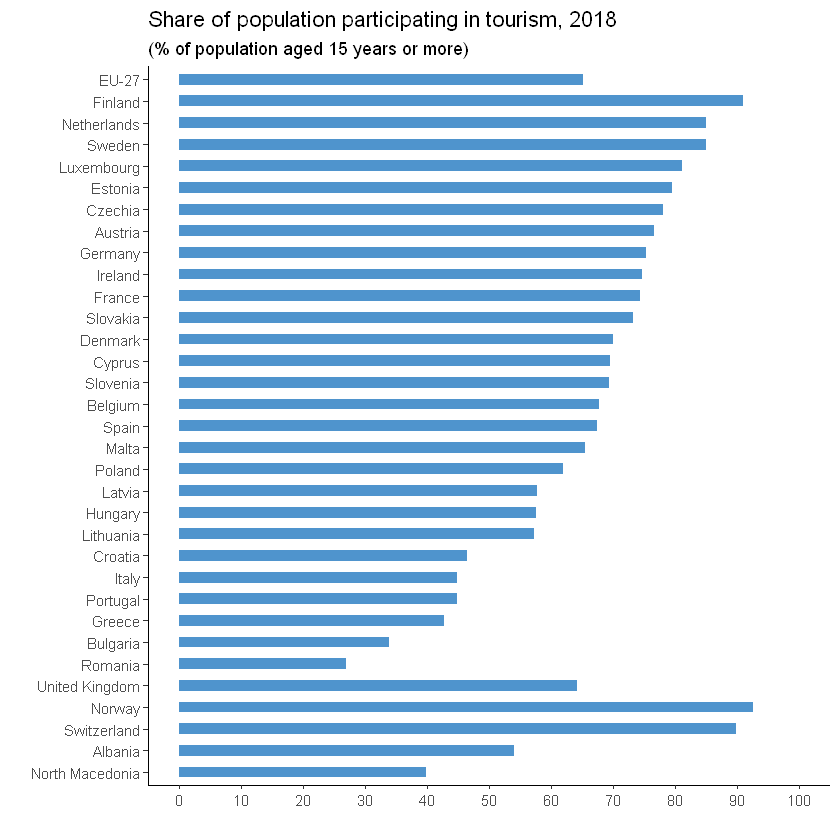

In [343]:
# you can do this due to modify the levels of the variable "geo"
data_tab2_part5$geo <- factor(data_tab2_part5$geo,
                        levels = c("EU-27","FI", "NL","SE","LU","EE","CZ","AT","DE","IE","FR","SK","DK","CY","SI","BE",
                                   "ES","MT","PL","LV","HU","LT","HR","IT","PT","EL","BG","RO", "UK", "NO","CH","AL","MK"))

# plot the graph via ggplot
ggplot(data_tab2_part5, aes(x=geo,y=values)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            theme_classic() +
            scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10)) +
            ggtitle("Share of population participating in tourism, 2018",
                   subtitle="(% of population aged 15 years or more)") +
            coord_flip()+
            scale_x_discrete(limits = rev(levels(data_tab2_part5$geo)),
                             labels = c("North Macedonia", "Albania", "Switzerland", "Norway", "United Kingdom", 
                                        "Romania", "Bulgaria", "Greece", "Portugal", "Italy", "Croatia", "Lithuania", 
                                        "Hungary", "Latvia", "Poland", "Malta", "Spain", "Belgium", "Slovenia", "Cyprus", 
                                        "Denmark", "Slovakia", "France", "Ireland", "Germany", "Austria", "Czechia", 
                                        "Estonia", "Luxembourg", "Sweden", "Netherlands", "Finland", "EU-27")) +
            ylab(" ") +
            xlab(" ")

# Nights spent abroad by EU-27 residents: Luxembourg leads in nights per inhabitant

## create figure 6

In [344]:
# load the data
data_fig6 <- get_eurostat(id="tour_dem_tntot")

# again we add a year-column
data_fig6$year <- as.integer(substr(data_fig6$time,1,4))

# create a new contry vector and exclude the countries, which need data from 2017
countr_fig6 <- countr <- c("ES","IT","FR","EL","AT","DE","HR","PT","NL","CZ","BE","BG","IE","CY","SE","HU","DK","SI",
                           "MT","FI","SK","EE","LV","LT","LU","UK","CH","NO","IS","LI","TR","ME","RS","MK","XK")
data_fig6_subs <- subset(data_fig6, 
                    data_fig6$geo %in% countr_fig6 & 
                    data_fig6$year==2018 &
                    data_fig6$purpose=="TOTAL" &
                    data_fig6$duration=="N_GE1"&
                    data_fig6$unit=="NR"&
                    data_fig6$partner=="OUT")
data_fig6_subs <- data_fig6_subs[,c(5,7)]

# for Poland we need data from 2017
countr_fig6_2 <- c("PL","RO")
data_fig6_subs2 <- subset(data_fig6, 
                    data_fig6$geo %in% countr_fig6_2 & 
                    data_fig6$year==2017 &
                    data_fig6$purpose=="TOTAL" &
                    data_fig6$duration=="N_GE1"&
                    data_fig6$unit=="NR"&
                    data_fig6$partner=="OUT")
data_fig6_subs2 <- data_fig6_subs2[,c(5,7)]

# matching
data_fig6_subs <- rbind(data_fig6_subs,data_fig6_subs2)

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_dem_tntot_date_code_TF.rds
Table  tour_dem_tntot  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/tour_dem_tntot_date_code_TF.rds


In [345]:
# calculate the EU-27 value by summing up

# create a vector, which indicates due to FALSE and TRUE at the exact position, 
# which countries of data_fig6_subs$geo are within EU_27
# we can use again the EU_27 vector
EU_27_prep4 <- data_fig6_subs$geo %in% EU_27

# by using the sapply-command we can calculate the sum for the column of "data_fig6_subs"
tab_EU4 <- sapply(as.data.frame(data_fig6_subs[EU_27_prep4,2]),sum)

# add a column with the ratio we need for the pie chart
# build the ratio
tab_ratio2 <- cbind(data_fig6_subs,data_fig6_subs[2]/tab_EU4*100)
# just keep the EU-countries
tab_ratio2 <- tab_ratio2[EU_27_prep4,]
# sort the values decreasing
tab_ratio2 <- tab_ratio2[order(tab_ratio2[,3], decreasing=T),]

# keep the top 9 countries and summing up the others to "Rest of EU-27" by using again the sapply command
tab_ratio_top9_2 <- tab_ratio2[1:9,]
tab_ratio_other_2 <- tab_ratio2[10:27,]
tab_ratio_other_2_sum <- sapply(as.data.frame(tab_ratio_other_2[,3]),sum)

# add the sum to the top 9
tab_ratio_new_2 <- rbind(tab_ratio_top9_2[,c(1,3)], tab_ratio_other_2_sum)
tab_ratio_new_2

Warning message in `[<-.factor`(`*tmp*`, ri, value = 15.3142164698757):
"invalid factor level, NA generated"

,geo,values
,<fct>,<dbl>
7,DE,35.407430
13,FR,15.544253
22,NL,7.500622
25,SE,5.559875
11,ES,4.806601
28,PL,4.630022
17,IT,4.284631
2,BE,4.052285
1,AT,2.900065


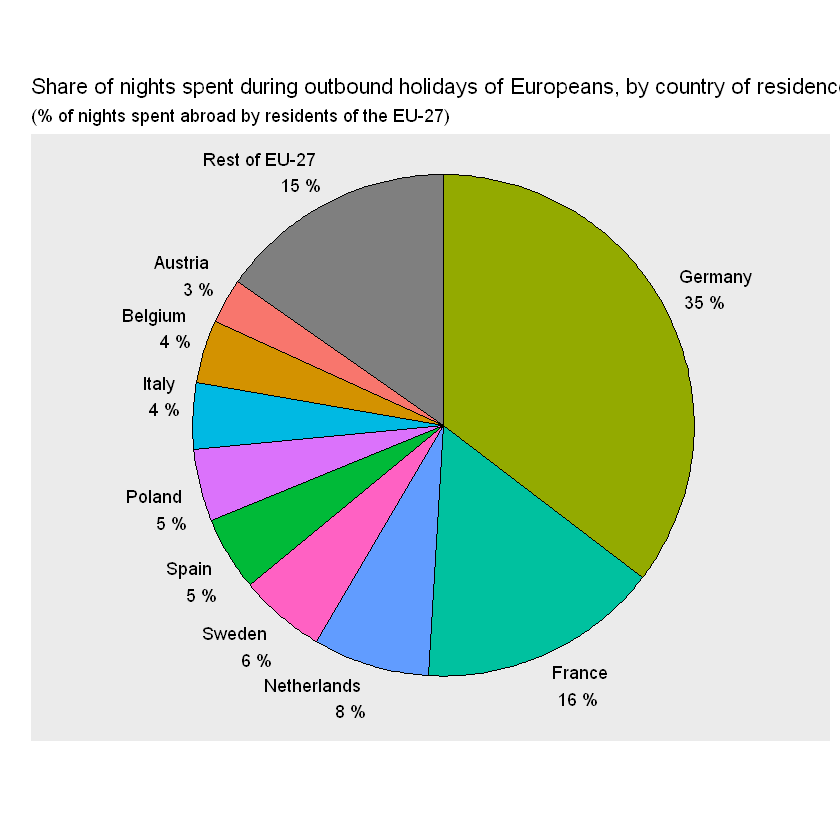

In [346]:
# create the labels we need for the pie chart
# round the values and put a "%" behind it
label_pie2_1 <- paste(round(tab_ratio_new_2$values,0), "%")
# create a vector with the needed country names
label_pie2_2 <- c("Germany","France","Netherlands","Sweden","Spain","Poland","Italy","Belgium",
                  "Austria","Rest of EU-27")
# combine the both created label parts
label_pie2_3 <- paste(label_pie2_2,"\n",label_pie2_1) #we can use a "/n" to get a line break

# create variables for the position of the labels in the pie chart
tab_ratio_new_2 <- tab_ratio_new_2 %>% 
  mutate(end = 2 * pi * cumsum(values)/sum(values),
         start = lag(end, default = 0),
         middle = 0.5 * (start + end),
         hjust = ifelse(middle > pi, 1, 0),
         vjust = ifelse(middle < pi/2 | middle > 3 * pi/2, 0, 1))

# plot the pie chart 
ggplot(tab_ratio_new_2) + 
  geom_arc_bar(aes(x0 = 0, y0 = 0, r0 = 0, r = 1,
                   start = start, end = end, fill = geo)) +
  geom_text(aes(x = 1.05 * sin(middle), y = 1.05 * cos(middle), label = label_pie2_3,
                hjust = hjust, vjust = vjust)) +
  coord_fixed() +
  scale_x_continuous(limits = c(-1.5, 1.4),  #Adjust so labels are not cut off
                     name = "", breaks = NULL, labels = NULL) +
  scale_y_continuous(limits = c(-1.15, 1.05),      #Adjust so labels are not cut off
                     name = "", breaks = NULL, labels = NULL) +
  ylab(" ") +
  xlab(" ") +
  theme(legend.position = "none") +
  theme(axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid  = element_blank()) +
  ggtitle("Share of nights spent during outbound holidays of Europeans, by country of residence of the tourist, 2018",
         subtitle="(% of nights spent abroad by residents of the EU-27)")

## create figure 7

In [347]:
# we need the number of population by people aged over 15 years
# load the data
data_fig7 <- get_eurostat(id="demo_pjanbroad")

# add again a year-column
data_fig7$year <- as.integer(substr(data_fig7$time,1,4))

#create a new country vector
countr_fig7 <- c("LU","SE","CY","NL","IE","DE","FI","EE","BE","AT","DK","SI","MT","FR","LT","SK",
                 "CZ","LV","HU","PL","HR","ES","IT","PT","BG","EL","RO","CH","NO")

Reading cache file C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/demo_pjanbroad_date_code_TF.rds
Table  demo_pjanbroad  read from cache file:  C:\Users\sarah\AppData\Local\Temp\RtmpUPWShX/eurostat/demo_pjanbroad_date_code_TF.rds


In [348]:
data_fig7_subs <- subset(data_fig7, 
                    data_fig7$geo %in% countr_fig7 & 
                    data_fig7$year==2018 &
                    data_fig7$age %in% c("Y15-64","Y_GE65") &
                    data_fig7$sex=="T")
data_fig7_subs <- data_fig7_subs[,c(4,6)]

# because we have per country several data points, we have to aggregate the data per country
data_fig7_subs <- aggregate(data_fig7_subs$values, by = list(geo = data_fig7_subs$geo), FUN = sum)

# bring the countries in the order the graphik shows (we have to do this for both needed datasets, 
# i.e. data_fig7_subs and data_fig6_subs)
data_fig6_subs_fig7 <- data_fig6_subs[order(factor(data_fig6_subs$geo, levels= countr_fig7)),]
data_fig7_subs_2 <- data_fig7_subs[order(factor(data_fig7_subs$geo, levels= countr_fig7)),]
# data_fig7_subs_2$geo; data_fig6_subs_fig7$geo #compare the countries: are they in the same order? then we can match.

# matching the two data frames and calculate the ratio
data_fig7_final <- cbind(data_fig6_subs_fig7,data_fig7_subs_2[,2])
data_fig7_final$ratio <- round(data_fig7_final[,2]/data_fig7_final[,3],1)

In [349]:
# calculate the EU-27 value by summing up

# create a vector, which indicates due to FALSE and TRUE at the exact position, 
# which countries of data_fig7_final$geo are within EU_27
# we can use again the EU_27 vector
EU_27_prep5 <- data_fig7_final$geo %in% EU_27

# by using the sapply-command we can calculate the sum for the column of "data_fig6_subs"
tab_EU5 <- sapply(as.data.frame(data_fig7_final[EU_27_prep5,2:3]),sum)

# calculate the ratio
tab_EU5_ratio <- round(tab_EU5[1]/tab_EU5[2],1)

# at this stage we get the warning message, that one NA for "Eu-27" get generated,
# we solve this problem two steps later
tab_EU5_final <- c("EU-27",tab_EU5,tab_EU5_ratio)

# put the calculates EU values to the table above
data_fig7_final <- rbind(tab_EU5_final,data_fig7_final)

# we have to convert the class, because we have to add "EU-27" and this only works by converting it from 
# a factor first, then doing the change and re-convert it back
data_fig7_final[,1] <- as.character(data_fig7_final[,1])
data_fig7_final[1,1] <- "EU-27"
data_fig7_final[,1] <- factor(data_fig7_final[,1])

data_fig7_final

Warning message in `[<-.factor`(`*tmp*`, ri, value = "EU-27"):
"invalid factor level, NA generated"

geo,values,"data_fig7_subs_2[, 2]",ratio
<fct>,<chr>,<chr>,<chr>
EU-27,2573268471,378201085,6.8
LU,15819287,504883,31.3
SE,143070504,8325565,17.2
CY,11955548,723947,16.5
NL,193011133,14418460,13.4
IE,50197497,3823944,13.1
DE,911128220,71620592,12.7
FI,55510398,4622706,12
EE,12292867,1103907,11.1


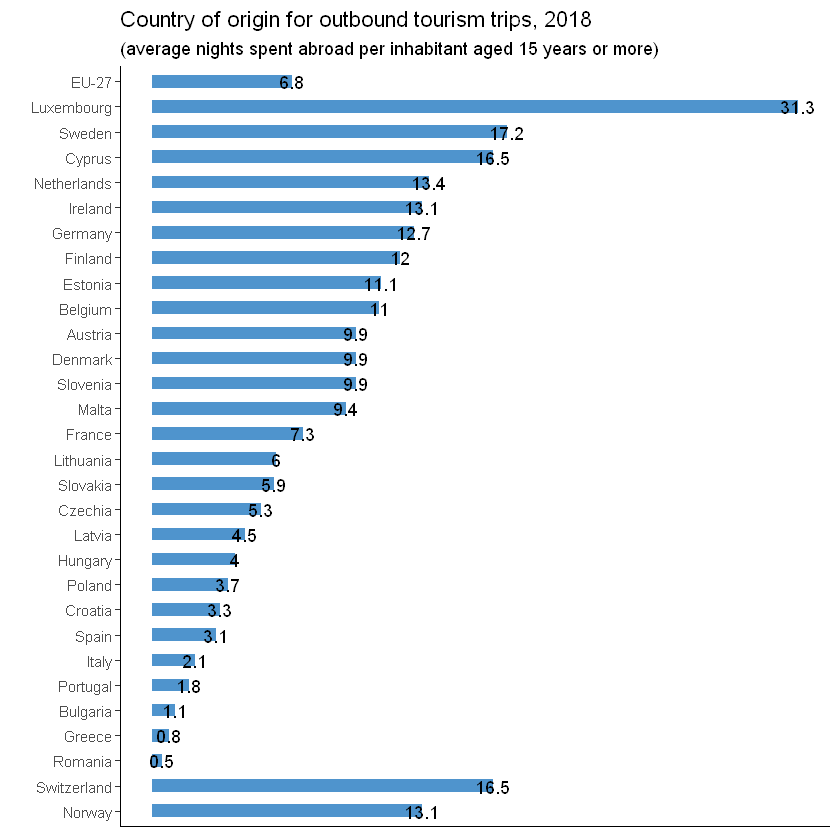

In [350]:
# bring the country names in the order the graphik shows
# you can do this due to modify the levels of the variable "geo"
data_fig7_final$geo <- factor(data_fig7_final$geo,
                        levels = c("EU-27","LU","SE","CY","NL","IE","DE","FI","EE","BE","AT","DK","SI","MT","FR","LT","SK",
                                   "CZ","LV","HU","PL","HR","ES","IT","PT","BG","EL","RO","CH","NO"))

# to achieve that the y-axes in the chart is later in an ascending order, we have to convert the ratio-axes to numeric
data_fig7_final$ratio <- as.numeric(as.character(data_fig7_final$ratio))

# plot the pie chart
ggplot(data_fig7_final, aes(x=geo,y=ratio)) +
            geom_bar(stat = "identity", position="dodge", width=0.5, fill="steelblue3") +
            theme_classic() +
            ggtitle("Country of origin for outbound tourism trips, 2018",
                   subtitle = "(average nights spent abroad per inhabitant aged 15 years or more)") +
            coord_flip()+
            scale_x_discrete(limits = rev(levels(data_fig7_final$geo)),
                             labels = c("Norway", "Switzerland", "Romania", "Greece", "Bulgaria", "Portugal", "Italy", 
                                        "Spain", "Croatia", "Poland", "Hungary", "Latvia", "Czechia", "Slovakia", 
                                        "Lithuania", "France", "Malta", "Slovenia", "Denmark", "Austria",
                                        "Belgium", "Estonia", "Finland", "Germany", "Ireland", "Netherlands",
                                        "Cyprus", "Sweden", "Luxembourg","EU-27")) +
            ylab(" ") +
            xlab(" ") +
            theme(axis.title.x=element_blank(), #remove labels at x-axes
                  axis.text.x=element_blank(),
                  axis.ticks.x=element_blank()) +
            geom_text(aes(label=ratio)) #add the ration values after the bars


# Tourism expenditure: highest spending by German residents

## create table 3